In [1]:
#librariries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('default')

import os
from livelossplot import PlotLossesKerasTF
import tensorflow as tf 
import keras
import cv2
from random import Random as random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [2]:
#load the dataset
train_dir = '../data/train/'
test_dir= '../data/test/'
os.listdir(train_dir)

['happy',
 '.DS_Store',
 'sad',
 'fear',
 'surprise',
 'neutral',
 'angry',
 'disgust']

In [3]:
#visualizing the image classes
def Class_count(path, name):
    class_dict = {}
    # Ensure the path ends with a separator
    if not path.endswith(os.path.sep):
        path += os.path.sep
    
    # Iterate over directories in the given path
    for c in os.listdir(path):
        full_path = os.path.join(path, c)
        if os.path.isdir(full_path):  # Check if it's a directory
            class_dict[c] = len(os.listdir(full_path))  # Count files in the directory

    # Create a DataFrame
    df = pd.DataFrame(list(class_dict.items()), columns=[name, 'Count'])
    return df


Train_count = Class_count(train_dir, 'image_name').sort_values(by='Count', ascending=False).rename(columns={'Count':'Train_Count'}).reset_index(drop=True)
Test_count = Class_count(test_dir,"image_name").sort_values(by="Count",ascending=False).rename(columns={'Count':'Test_Count'}).reset_index(drop=True)

In [4]:
merged_df=pd.merge(Train_count,Test_count, on= 'image_name')
merged_df.set_index('image_name',inplace=True)
merged_df

,Train_Count,Test_Count
image_name,,
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: ylabel='image_name'>

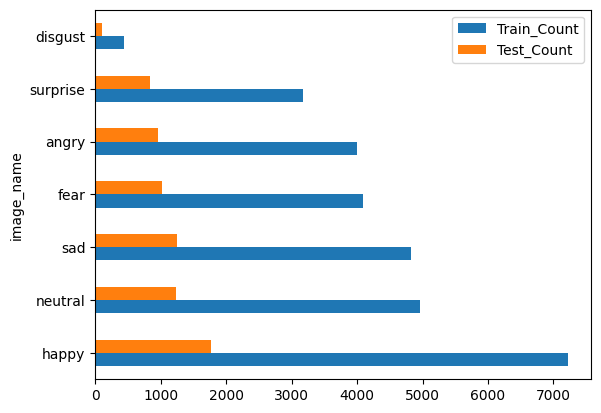

In [5]:
# plotting the image
merged_df.plot(kind='barh')

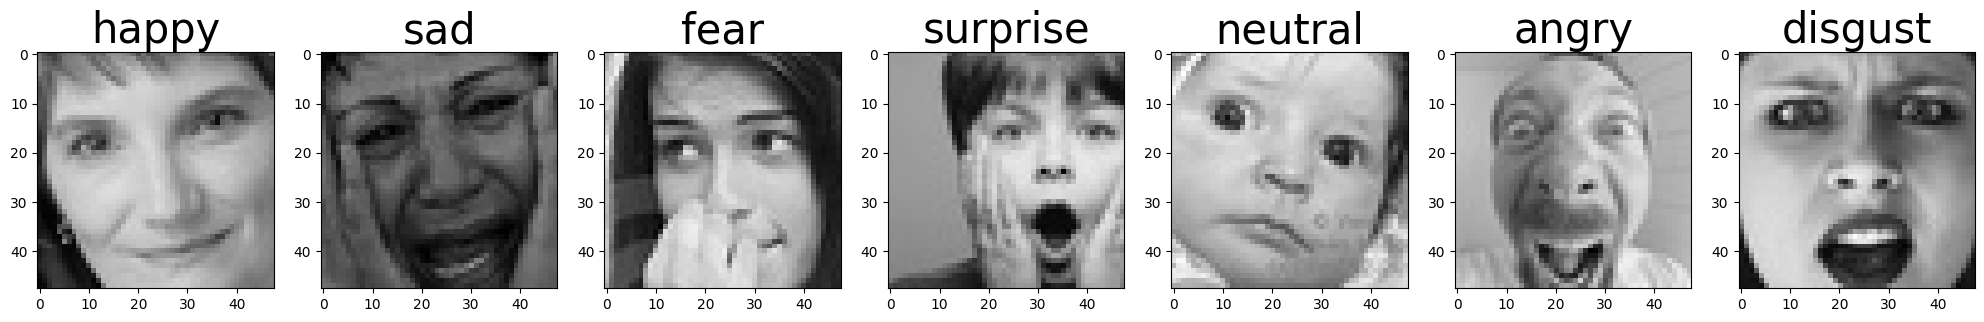

In [6]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1

for directory in os.listdir(train_dir):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(train_dir+ directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(train_dir + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 30)

In [7]:
img_size = 48
batch_size = 64 # denote the number of image will process in one pass by model
train_preprocessor = ImageDataGenerator(
    rescale = 1/255.,
    #Data Augmentation
    rotation_range = 10,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split=0.2,

    
)
test_preprocessor = ImageDataGenerator(rescale=1/255.,
                                    )

train_generator = train_preprocessor.flow_from_directory(
    '../data/train/',
    class_mode = "categorical",
    target_size=(img_size,img_size),
    color_mode='grayscale',
    shuffle=True,
    batch_size=batch_size,
    subset = 'training',
    
)
validation_generator = train_preprocessor.flow_from_directory(
    '../data/train/',
    class_mode = "categorical",
    target_size=(img_size,img_size),
    color_mode='grayscale',
    shuffle=True,
    batch_size=batch_size,
    subset = 'validation',
    
)

test_generator = test_preprocessor.flow_from_directory(
    '../data/test/',
    class_mode = "categorical",
    target_size=(img_size,img_size),
    color_mode='grayscale',
    shuffle=False,
    batch_size=batch_size,
    
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
def Create_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model



In [16]:
model = Create_Model()
model.summary()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,347,719 (20.40 MB)

 Trainable params: 5,344,199 (20.39 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [21]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy',precision,recall])

In [18]:
# Create Callback Checkpoint
checkpoint_path = "CNN_model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
#Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 11, restore_best_weights = True, verbose=1, min_delta=0.00005)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=7, mode='auto', min_lr=1e-7,verbose=1)



callbacks = [PlotLossesKerasTF(),Checkpoint, Reducing_LR]
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

In [19]:
print(steps_per_epoch)
print(validation_steps)

358
89


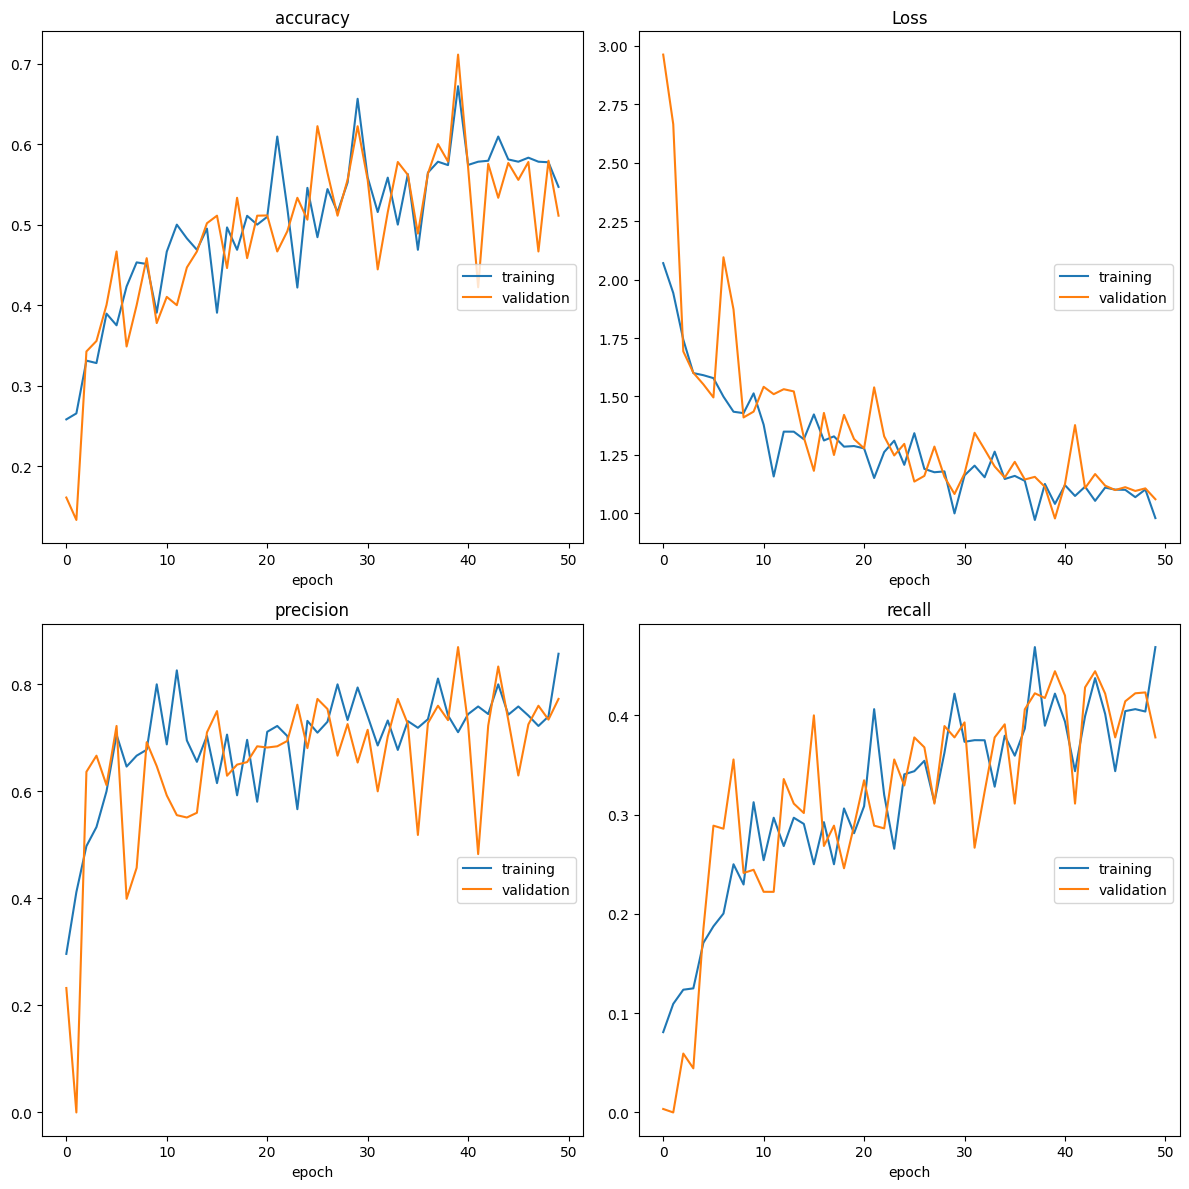

accuracy
	training         	 (min:    0.258, max:    0.672, cur:    0.547)
	validation       	 (min:    0.133, max:    0.711, cur:    0.511)
Loss
	training         	 (min:    0.971, max:    2.070, cur:    0.979)
	validation       	 (min:    0.978, max:    2.963, cur:    1.060)
precision
	training         	 (min:    0.296, max:    0.857, cur:    0.857)
	validation       	 (min:    0.000, max:    0.870, cur:    0.773)
recall
	training         	 (min:    0.081, max:    0.469, cur:    0.469)
	validation       	 (min:    0.000, max:    0.444, cur:    0.378)
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5469 - loss: 0.9794 - precision: 0.8571 - recall: 0.4688 - val_accuracy: 0.5111 - val_loss: 1.0601 - val_precision: 0.7727 - val_recall: 0.3778 - learning_rate: 1.5625e-05


In [22]:
model_history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
)

In [23]:
CNN_Score = model.evaluate(test_generator)
final_accuracy = model_history.history['accuracy'][-1]

print("Test Loss     : {:.5f}".format(CNN_Score[0]))
print("Test Accuracy : {:.2f}%".format(CNN_Score[1] * 100))
print("Final Accuracy        : {:.2%}".format(final_accuracy))

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5727 - loss: 1.1292 - precision: 0.6965 - recall: 0.4293
Test Loss     : 1.04557
Test Accuracy : 60.63%
Final Accuracy        : 54.69%


In [24]:
CNN_predictions = model.predict(test_generator)
CNN_predictions = np.argmax(CNN_predictions, axis = 1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step


Text(0.5, 1.0, 'Confusion matrix of model ')

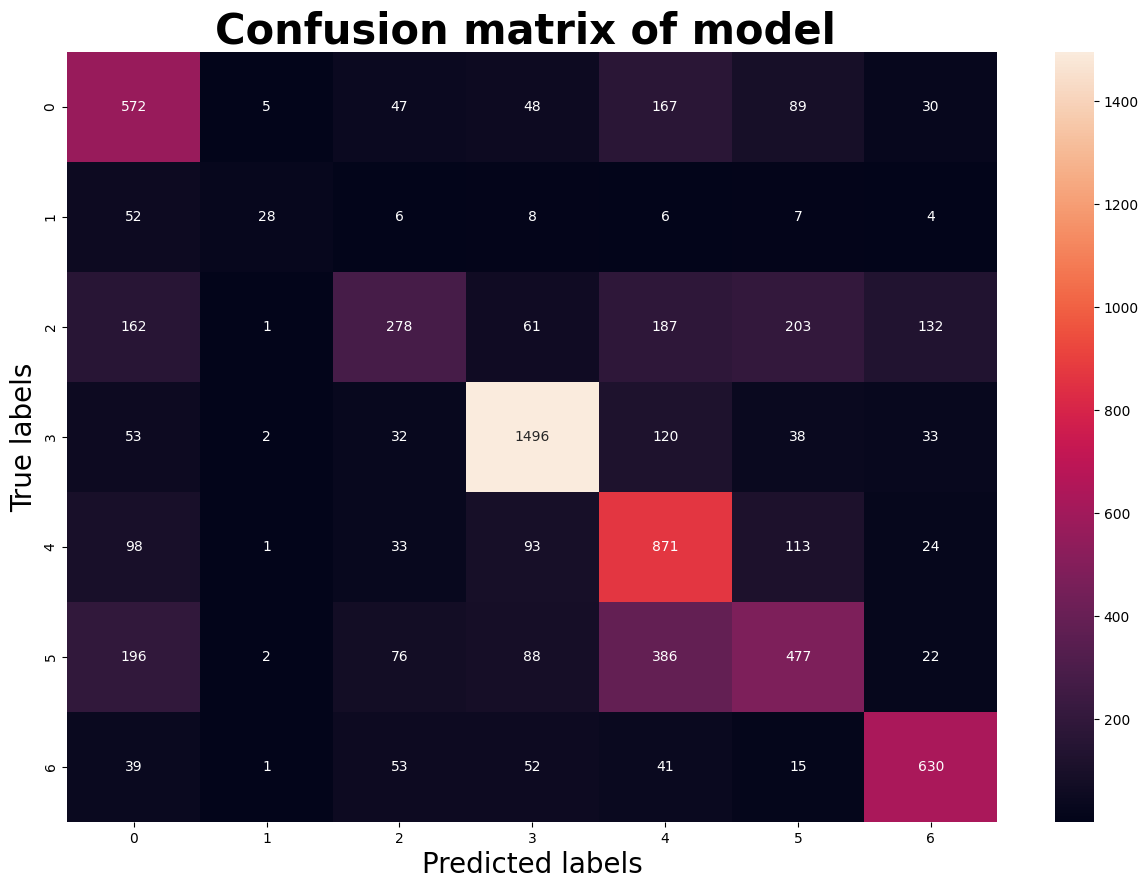

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig,ax = plt.subplots(figsize=(15,10))
conf = confusion_matrix(test_generator.labels, CNN_predictions)
sns.heatmap(conf,annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 20)
ax.set_ylabel('True labels', fontsize = 20)
ax.set_title('Confusion matrix of model ', fontsize = 30, fontweight = 'bold')

In [26]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

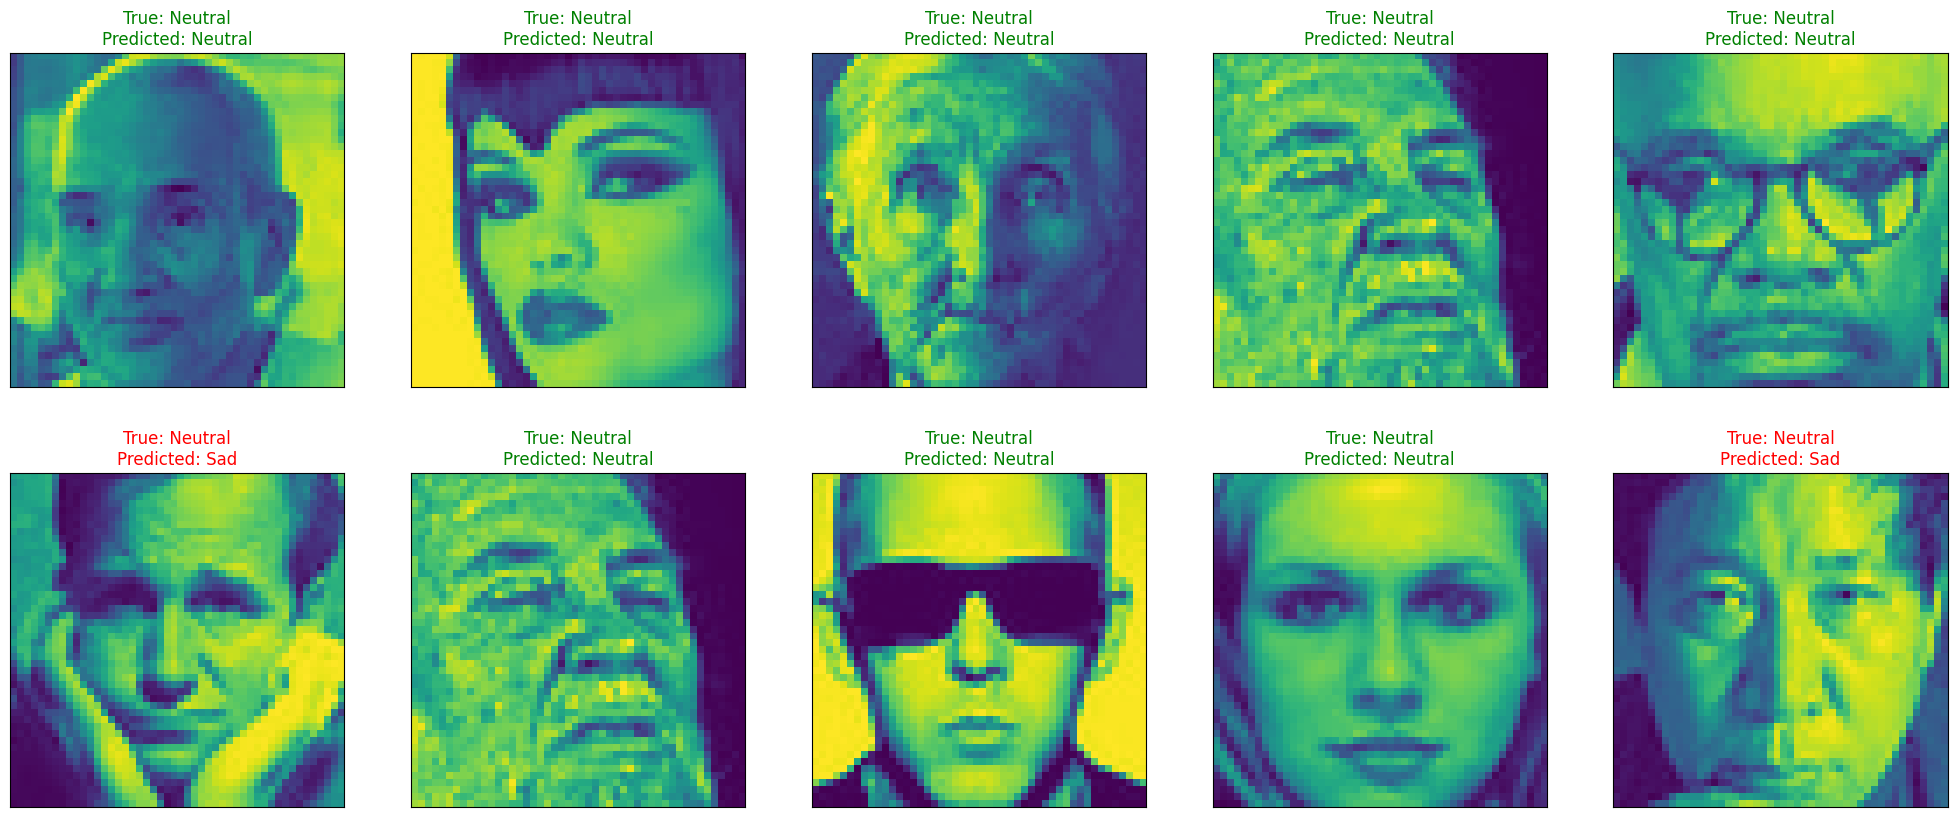

<Figure size 640x480 with 0 Axes>

In [27]:
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    CNN_predictions = np.argmax(model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[CNN_predictions]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[CNN_predictions]}", color=color)
plt.show()
plt.tight_layout()

In [30]:
model.save("FinalModel54-60.keras")


In [33]:
Final_model = Create_Model()
Final_model.summary()
Final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,347,719 (20.40 MB)

 Trainable params: 5,344,199 (20.39 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [34]:
#let increase the number of epoch and again trained the model
# Create Callback Checkpoint
checkpoint_path = "CNN_model_Checkpoint1.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=11, mode='auto', min_lr=1e-7,verbose=1)



callbacks = [PlotLossesKerasTF(),Checkpoint, Reducing_LR]
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

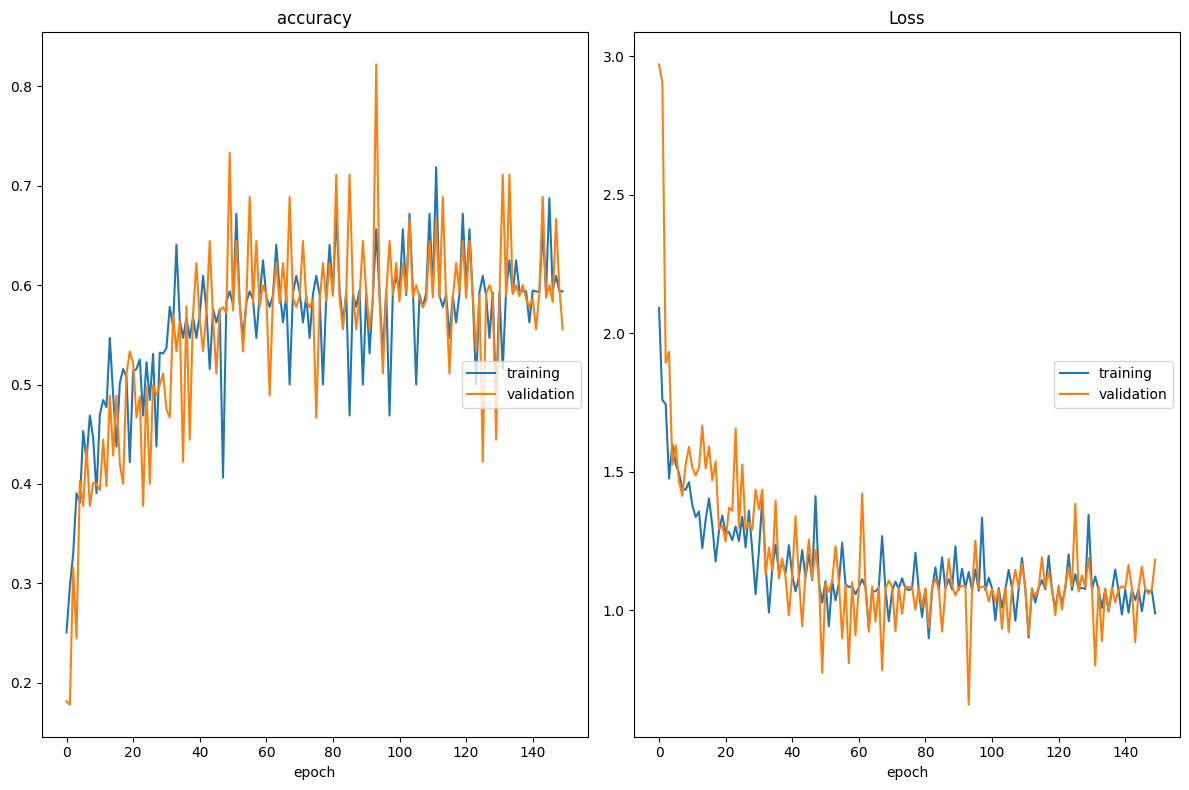

accuracy
	training         	 (min:    0.251, max:    0.719, cur:    0.594)
	validation       	 (min:    0.178, max:    0.822, cur:    0.556)
Loss
	training         	 (min:    0.900, max:    2.091, cur:    0.989)
	validation       	 (min:    0.660, max:    2.970, cur:    1.184)
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.5938 - loss: 0.9891 - val_accuracy: 0.5556 - val_loss: 1.1838 - learning_rate: 1.0000e-07


In [35]:
Final_history = Final_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
)

In [38]:
FCNN_Score = Final_model.evaluate(test_generator)
Final_accuracy = Final_history.history['accuracy'][-1]

print("Test Loss     : {:.5f}".format(FCNN_Score[0]))
print("Test Accuracy : {:.2f}%".format(FCNN_Score[1] * 100))
print("Final Accuracy        : {:.2%}".format(Final_accuracy))

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5809 - loss: 1.1148
Test Loss     : 1.02198
Test Accuracy : 61.59%
Final Accuracy        : 59.38%


In [41]:
CNN_Predictions = Final_model.predict(test_generator)
CNN_Predictions = np.argmax(CNN_Predictions, axis = 1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


Text(0.5, 1.0, 'Confusion matrix of model ')

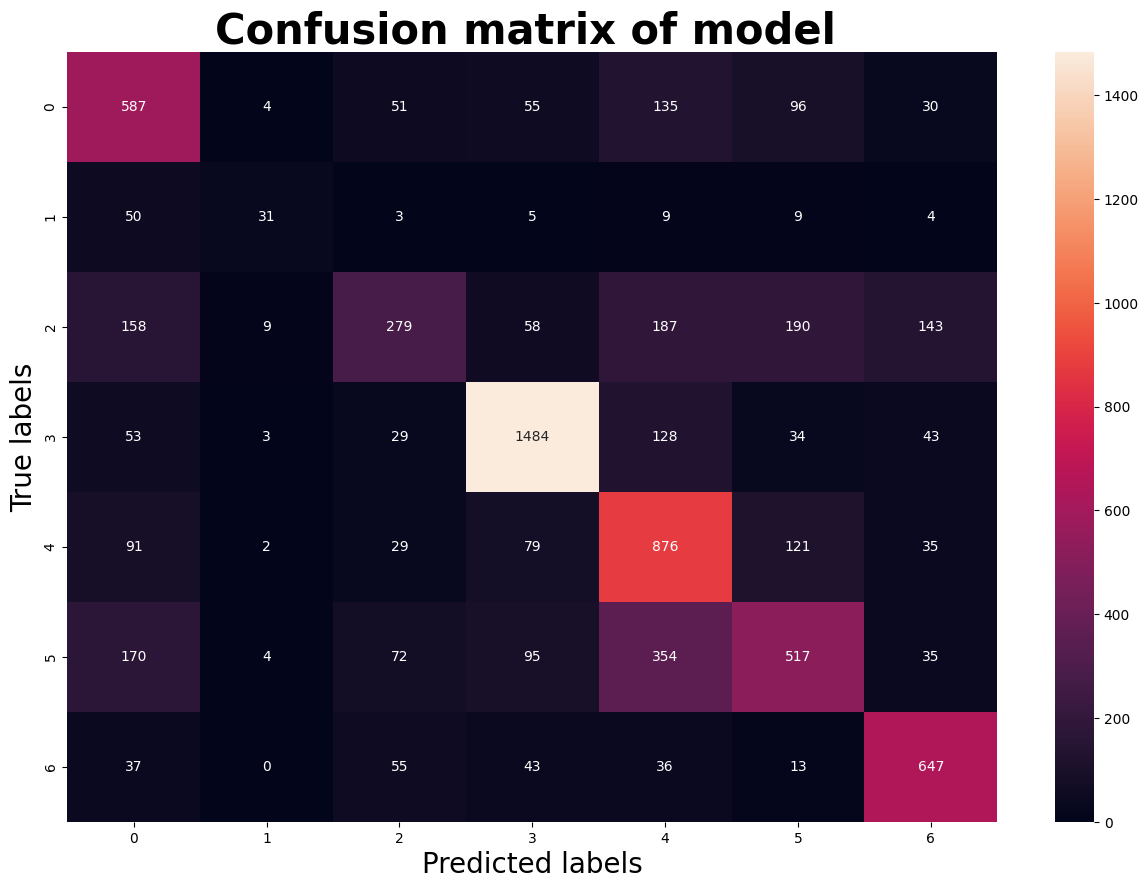

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig,ax = plt.subplots(figsize=(15,10))
Conf = confusion_matrix(test_generator.labels, CNN_Predictions)
sns.heatmap(Conf,annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 20)
ax.set_ylabel('True labels', fontsize = 20)
ax.set_title('Confusion matrix of model ', fontsize = 30, fontweight = 'bold')

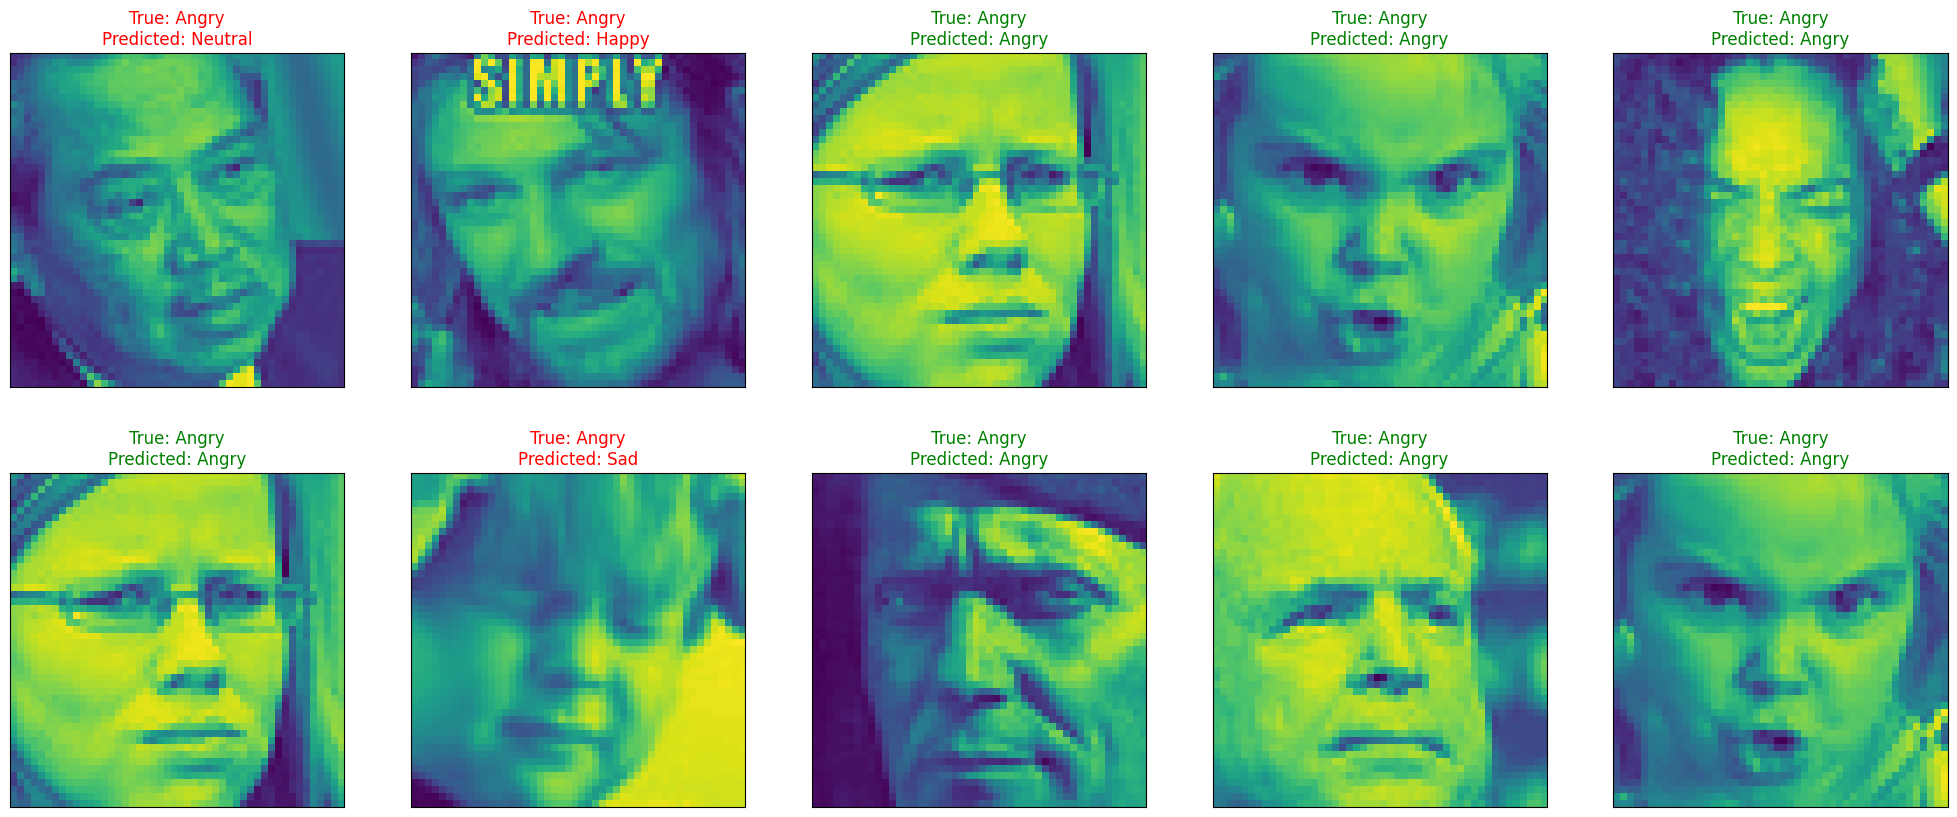

<Figure size 640x480 with 0 Axes>

In [44]:
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    CNN_Predictions = np.argmax(Final_model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[CNN_Predictions]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[CNN_Predictions]}", color=color)
plt.show()
plt.tight_layout()

In [45]:
model.save("FinalModel59-61.keras")


In [13]:
# lets train the model without using earling stoping an reducing lr
Final_model1 = Create_Model()
Final_model1.summary()
Final_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,347,719 (20.40 MB)

 Trainable params: 5,344,199 (20.39 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [14]:
checkpoint_path = "CNN_model_Checkpoint2.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
callbacks = [PlotLossesKerasTF(),Checkpoint]
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

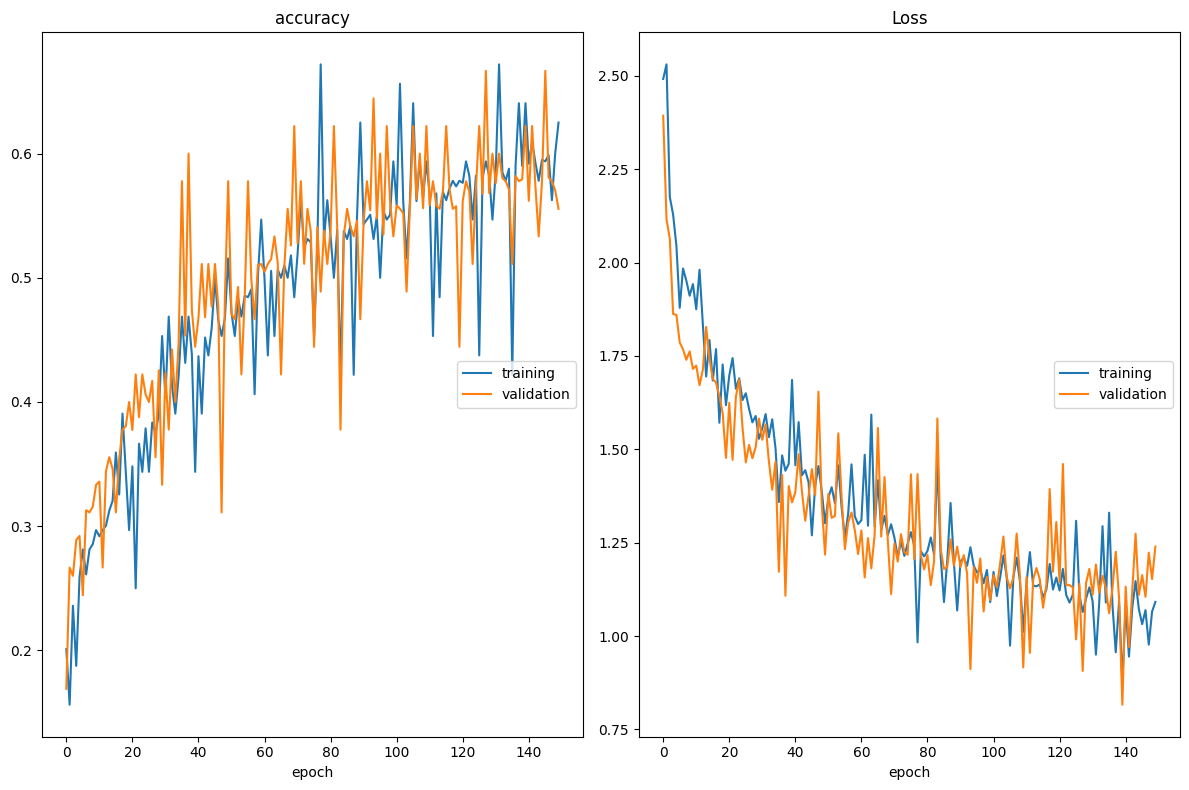

accuracy
	training         	 (min:    0.156, max:    0.672, cur:    0.625)
	validation       	 (min:    0.169, max:    0.667, cur:    0.556)
Loss
	training         	 (min:    0.877, max:    2.531, cur:    1.091)
	validation       	 (min:    0.816, max:    2.393, cur:    1.240)
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6250 - loss: 1.0913 - val_accuracy: 0.5556 - val_loss: 1.2395


In [15]:
Final_history1 = Final_model1.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
)

In [16]:
FCNN_Score1 = Final_model1.evaluate(test_generator)
Final_accuracy1 = Final_history1.history['accuracy'][-1]

print("Test Loss     : {:.5f}".format(FCNN_Score1[0]))
print("Test Accuracy : {:.2f}%".format(FCNN_Score1[1] * 100))
print("Final Accuracy        : {:.2%}".format(Final_accuracy1))

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5420 - loss: 1.2303
Test Loss     : 1.11646
Test Accuracy : 59.21%
Final Accuracy        : 62.50%


In [17]:
CNN_Predictions1 = Final_model1.predict(test_generator)
CNN_Predictions1 = np.argmax(CNN_Predictions1, axis = 1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step


Text(0.5, 1.0, 'Confusion matrix of model ')

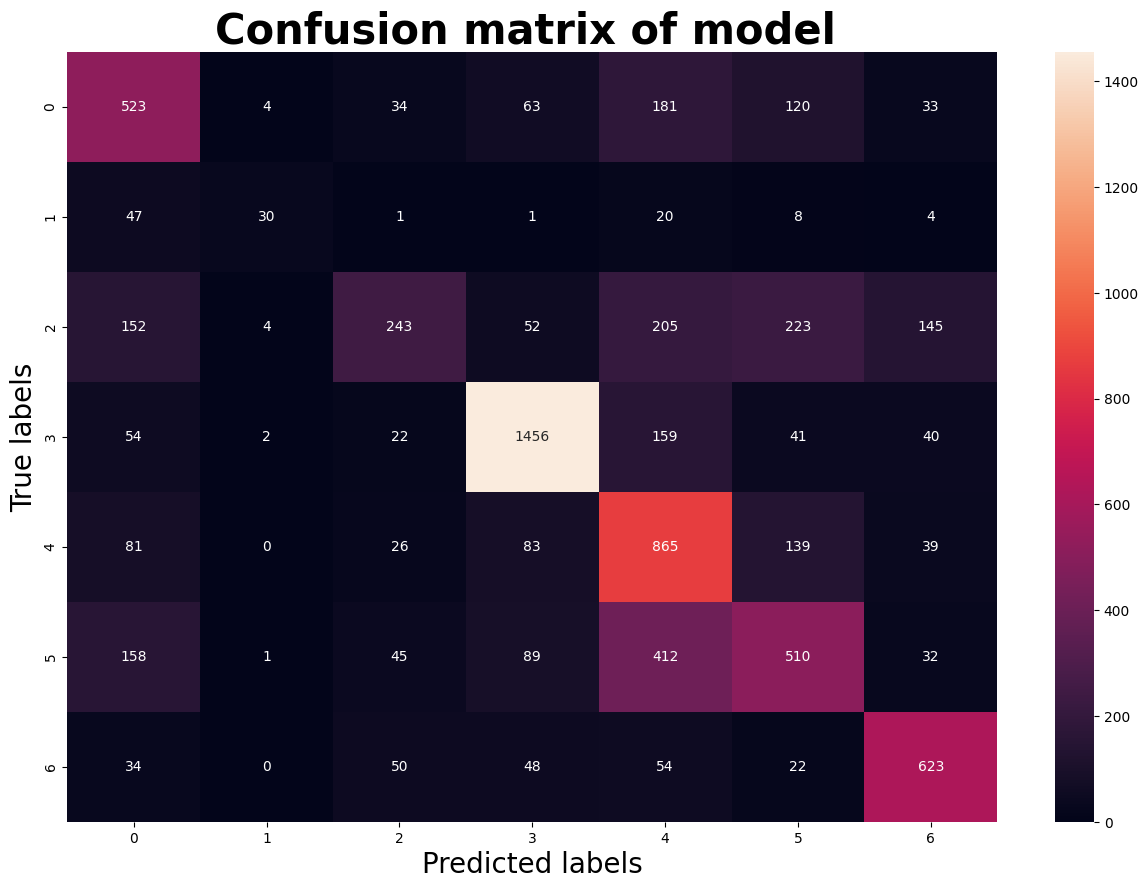

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig,ax = plt.subplots(figsize=(15,10))
Conf1 = confusion_matrix(test_generator.labels, CNN_Predictions1)
sns.heatmap(Conf1,annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 20)
ax.set_ylabel('True labels', fontsize = 20)
ax.set_title('Confusion matrix of model ', fontsize = 30, fontweight = 'bold')